<a href="https://colab.research.google.com/github/PaulinaIvan/GMM/blob/master/GMM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Autorius: Paulina Ivanauskaitė
*   LSP: 2213728
*   Variantas: Naudotas ResNet50 modelis su liūto, tigro ir leopardo klasėmis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torchvision.transforms as transforms

Dataset preprocesuoja (paverčia į RGB ir transformuoja) nuotraukas, dirba kartu su dataloader. Įgyvendintos pagrindinės funkcijos reikalingos Dataset klasės inicializavimui (init, len ir getitem)

In [17]:
class BigCatDataset(Dataset):
    def __init__(self, base_dir, transform):
        self.transform = transform
        self.samples = []

        for cls in ['lion', 'tiger', 'leopard']:
            class_path = Path(f"/content/drive/MyDrive/ColabNotebooks/{base_dir}")  / cls
            if class_path.exists():
                self.samples.extend([(str(p), cls) for p in class_path.glob('*.jpg')])

        print(f"Found {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        try:
            with PIL.Image.open(img_path) as img:
                img = img.convert('RGB')
                if self.transform:
                    img = self.transform(img)
                return img, 0, cls
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, 224, 224)), 0, cls

Inicializuojame modelį (Resnet50), nustatome reikiamas klases.

In [18]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

class_indices = {
    'lion': weights.meta["categories"].index('lion'),
    'tiger': weights.meta["categories"].index('tiger'),
    'leopard': weights.meta["categories"].index('leopard')
}

print("Model initialized with class indices:")
for cls, idx in class_indices.items():
    print(f"{cls}: {idx}")

Model initialized with class indices:
lion: 291
tiger: 292
leopard: 288


Inicializuojame Dataset ir DataLoader. Dataset įgauna direktoriją su nuotraukomis ir transformaciją (šiuo atveju preprocess). DataLoader inicializuojame su norimos reikšmėm (rinkinio dydis, darbuotojų kiekis ir t. t.)

In [29]:
dataset = BigCatDataset('big_cat_dataset', transform=preprocess)
data_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    prefetch_factor=2,
    persistent_workers=True,
    multiprocessing_context='fork'
)

print(f"Dataset size: {len(dataset)} images")
print(f"Using {data_loader.num_workers} workers")
print(f"Using GPU: {torch.cuda.is_available()}")


Found 1000 images
Dataset size: 1000 images
Using 1 workers
Using GPU: True


Susirenkam spėjimus (predictions). Jei naudojome GPU, tada po procesavimo grąžinam spėjimus atgal į CPU.

In [30]:
all_predictions = []
all_true_classes = []

model.eval()
with torch.no_grad():
    for batch_images, _, batch_classes in tqdm(data_loader):
        if torch.cuda.is_available():
            batch_images = batch_images.cuda()
            model = model.cuda()
        predictions = model(batch_images).softmax(dim=1)
        predictions = predictions.cpu()
        all_predictions.append(predictions)
        all_true_classes.extend(batch_classes)
all_predictions = torch.cat(all_predictions, dim=0)

results = {
    'predictions': all_predictions,
    'true_classes': all_true_classes,
    'class_indices': class_indices
}

100%|██████████| 32/32 [02:16<00:00,  4.26s/it]


Skaičuojame rezultatus, pagal funkcijas:

$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$

$Recall = \frac{TP}{TP + FN}$

$Precision = \frac{TP}{TP + FP}$

$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$

In [13]:
def calculate_metrics(threshold):
    predictions = results['predictions']
    true_classes = results['true_classes']
    class_indices = results['class_indices']

    classes = ['lion', 'tiger', 'leopard']
    metrics = {}

    for cls in classes:
        idx = class_indices[cls]
        pred_values = predictions[:, idx]
        pred_binary = (pred_values > threshold)

        is_current_class = torch.tensor([label == cls for label in true_classes])

        tp = torch.sum((pred_binary) & (is_current_class)).float()
        fp = torch.sum((pred_binary) & (~is_current_class)).float()
        tn = torch.sum((~pred_binary) & (~is_current_class)).float()
        fn = torch.sum((~pred_binary) & (is_current_class)).float()

        total = float(len(true_classes))

        precision = (tp / (tp + fp)).item() if (tp + fp) > 0 else 0
        recall = (tp / (tp + fn)).item() if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / total
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[cls] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    return metrics

Šioje vietoje kviečiame statistikos skaičiavimo funkciją (calculate_metrics) su norima slenkstine reikšme (threshold). Rezultatus parodome kiekvienai klasei.

In [15]:
threshold = 0.5
metrics = calculate_metrics(threshold)

print(f"\nResults with threshold {threshold}:")
for cls, cls_metrics in metrics.items():
    print(f"\n{cls.capitalize()}:")
    for metric, value in cls_metrics.items():
        print(f"{metric}: {value:.3f}")


Results with threshold 0.5:

Lion:
accuracy: 0.716
precision: 1.000
recall: 0.157
f1: 0.272

Tiger:
accuracy: 0.665
precision: 1.000
recall: 0.054
f1: 0.102

Leopard:
accuracy: 0.710
precision: 1.000
recall: 0.061
f1: 0.116


Papildomai: preciziškumo (precision) ir atkūrimo (recall) santykį atvaizduojame diagramoje.

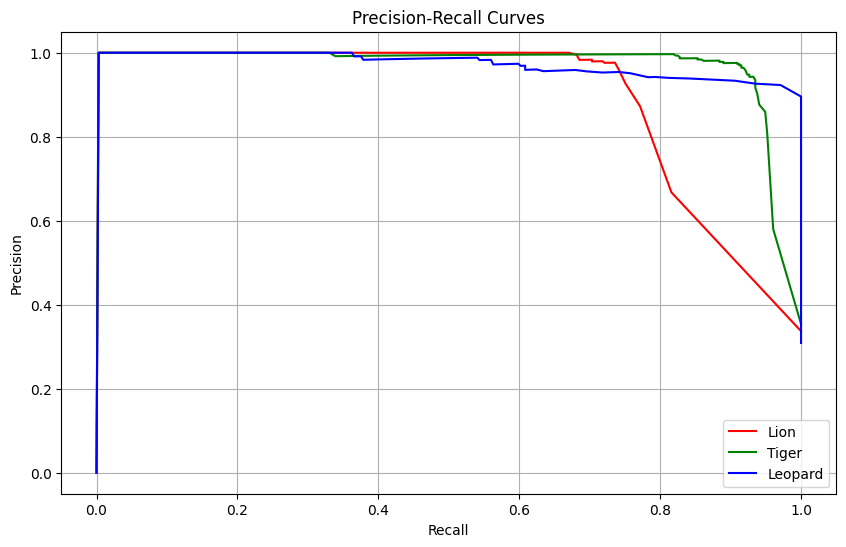

In [28]:
class_names=['lion', 'tiger', 'leopard']
plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b']

for cls, color in zip(class_names, colors):
    precisions = []
    recalls = []

    for threshold in np.linspace(0, 1, 1000):
        metrics = calculate_metrics(results, threshold)
        precisions.append(metrics[cls]['precision'])
        recalls.append(metrics[cls]['recall'])

    plt.plot(recalls, precisions, color=color, label=cls.capitalize())

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()